# Sumatra export

In [3]:
import json
import pandas
import numpy as np

!smt export
with open('.smt/records_export.json') as ff:
    data = json.load(ff)
    
with open('record1.json', 'w') as record1:
    for entry in range(len(data)):
        record1.write(json.dumps(data[entry], sort_keys=True, indent=4, separators=(',', ': ')))

df = pandas.DataFrame(data)  #df is now the sumatra dataframe

# Extractor() : 

This method finds the simulations which have ".mpz.npz" files in their Data/ folder and gets all the information out of those files into a dataframe


In [4]:
import glob
import os
import fipy as fp

# print df['output_data'][0][-2]['path']
# df['datastore'][0]['parameters']['root']  #alternative method to get data directory

labels = []

# labels = df['label']
labels = ['fafbeb433621', 'd88bca02dcc7', '555a1eed5f55', '87010a682e4d', '7eff0b0d7455', 'd5ba58775177', '8851d4ef0b49', '9656864915ad', 'bc94d63e65a8' ] #I manually entered simulations that were ok
print labels

dfC = pandas.DataFrame(columns=['label','steps','elapsed', 'nx', 'ny', 'c_var_array', 'cvar_Interpolated_Function', 'dt', 'dx', 'dy', 'sweeps', 'L1', 'L2', 'Linf'])

def extractor(labelz, Lx=200.):  
    rows = 0
    for lbl in labelz:
        dictt = {} #create a dictionary to fill in with simulation data
        dictt.update({'label':lbl})
        p = str(df['datastore'][0]['parameters']['root'])
        p = p[:-13] #cuts off the sumatra label from the datapath
        datapath = os.path.join(p, lbl)
        mfile = glob.glob('{0}/*.mpz.npz'.format(datapath)) #get the name of the mpz file with data we need
#         print mfile
        if len(mfile)>=1:
            for mpzfile in mfile:
                fn = np.load(mpzfile)
                for item in fn:
                    dictt.update({str(item):fn[item]}) #add every variable from the file into the dictionary
                dictt.update({'cvar_Interpolated_Function':None}) #create a blank column for later
                dictt.update({'L1':[]})
                dictt.update({'L2':[]})
                dictt.update({'Linf':[]})

                #now we need the x and y coordinates for interpolation to match the grid size
                nx = dictt['nx']
                ny = dictt['ny']

#                 print dictt.keys()
#                 print rows
                dfC.loc[rows]=dictt        
                rows+=1
    return dfC #dfC is a compact dataframe with all the information we need
        
extractor(labels)

['fafbeb433621', 'd88bca02dcc7', '555a1eed5f55', '87010a682e4d', '7eff0b0d7455', 'd5ba58775177', '8851d4ef0b49', '9656864915ad', 'bc94d63e65a8']


,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf
0,fafbeb433621,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,3,[],[],[]
1,fafbeb433621,43,5.0,100,100,"[0.538726025473, 0.551850637422, 0.55003077790...",None,0.104952481839,2.0,2.0,3,[],[],[]
2,fafbeb433621,51,10.0,100,100,"[0.5833090875, 0.601243470851, 0.600634731549,...",None,0.276794734012,2.0,2.0,3,[],[],[]
3,fafbeb433621,62,20.0,100,100,"[0.592772135132, 0.606466476192, 0.60487321399...",None,0.444615342716,2.0,2.0,3,[],[],[]
4,fafbeb433621,107,100.0,100,100,"[0.584911259609, 0.554134101807, 0.50933111079...",None,0.000477116988293,2.0,2.0,3,[],[],[]
5,fafbeb433621,168,200.0,100,100,"[0.537517884553, 0.504885738303, 0.46325649396...",None,1.96908172607,2.0,2.0,3,[],[],[]
6,fafbeb433621,291,500.0,100,100,"[0.445400625063, 0.41610932809, 0.388169791056...",None,1.22996861185,2.0,2.0,3,[],[],[]
7,d88bca02dcc7,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,2,[],[],[]
8,d88bca02dcc7,43,5.0,100,100,"[0.538726112675, 0.551850748491, 0.55003087979...",None,0.104952481839,2.0,2.0,2,[],[],[]
9,d88bca02dcc7,51,10.0,100,100,"[0.583120426534, 0.6009981981, 0.60039883956, ...",None,0.276794734012,2.0,2.0,2,[],[],[]


In [5]:
a = np.array((0, 1, 3))
a[:] = 5
print a

[5 5 5]


# cvar Interpolation

The method below will take the datafram which is created by the extractor() above and save the interpolation function into the dataframe

In [5]:
def Figures_of_Merit(dframe, Lx=200.):
    Lx = float(Lx)
    N_Best = 0
    sweeps_Best = 0
    c_var_Best = {}
    results = {}
    simulations = []
    full_keys = []
    key_Best = ''
    for row in dframe.iterrows():
        if row[1]['nx'] >= N_Best and row[1]['sweeps'] >= sweeps_Best:
            N_Best = row[1]['nx']
            sweeps_Best = row[1]['sweeps']
            key_Best = '{0}-{1}'.format(row[1]['nx'], row[1]['sweeps'])
            print key_Best
#     for row in dframe.iterrows():
#         c_var_Best[str(row[1]['elapsed'])] = np.array(row[1]['c_var_array']) #We need to update 
        
        key = '{0}-{1}-{2}'.format(row[1]['nx'], row[1]['sweeps'], row[1]['elapsed'])
        sim_key = '{0}-{1}'.format(row[1]['nx'], row[1]['sweeps'])
        if sim_key not in simulations: simulations.append(sim_key)
        if key not in full_keys: full_keys.append(key)
        results[key] = {'c_var': np.array(row[1]['c_var_array'])}
            
    simulations.append(key_Best)
    for key, value in results.iteritems():
        mesh_int = fp.Grid2D(nx=N_Best, ny=N_Best, dx=Lx / N_Best, dy=Lx / N_Best)
        N_sweeps_elapsed = key.split('-')
        N_sweeps_elapsed[0] = int(N_sweeps_elapsed[0])
        N_sweeps_elapsed[1] = int(N_sweeps_elapsed[1])
        m = fp.Grid2D(nx=N_sweeps_elapsed[0], ny=N_sweeps_elapsed[0], dx=Lx / N_sweeps_elapsed[0], dy=Lx / N_sweeps_elapsed[0])
        
        v = fp.CellVariable(mesh=m)
#         print value
        v[:] = value['c_var'][:]
        v_int = fp.CellVariable(mesh=mesh_int)
#         print N_Best, Lx / N_Best, Lx
#         print v.mesh.x[:10]
#         print v.mesh.y[:10]
#         print v_int.mesh.x[:10]
#         print v_int.mesh.y[:10]
        v_int[:] = v((mesh_int.x, mesh_int.y), order=1)
        
        elaps_cvar_Best = '{0}-{1}'.format(key_Best, N_sweeps_elapsed[2])
#         print ' '
#         print 'CHECK CHECK CHECK'
#         print 'Current key: ', key
#         print 'Corresponding Best Key :', elaps_cvar_Best
#         print 'The results of Best Key entry in dictionary: ', results[elaps_cvar_Best]
#         print '***The interpolated values : ', v_int
#         print 'content of testing array: ', v
#         print 'length of best array: ', len(v_int)
#         print '*******'
        diff_cvar_Best = np.absolute(results[elaps_cvar_Best]['c_var'] - v_int)
#         print 'The diff of {0} with {1}: '.format(key, elaps_cvar_Best), diff_cvar_Best
        value['L1'] = np.linalg.norm(diff_cvar_Best,1)
        value['L2'] = np.linalg.norm(diff_cvar_Best,2)
        value['Linf'] = np.linalg.norm(diff_cvar_Best,np.inf)
        
    for row in dframe.iterrows():
#         if row[1]['nx'] != N_Best and row[1]['sweeps'] != sweeps_Best:
            key = '{0}-{1}-{2}'.format(row[1]['nx'], row[1]['sweeps'], row[1]['elapsed'])
            row[1]['L1'] = results[key]['L1']
            row[1]['L2'] = results[key]['L2']
            row[1]['Linf'] = results[key]['Linf']
#         else:
#             row[1]['L1'] = 0
#             row[1]['L2'] = 0
#             row[1]['Linf'] = 0

    best_key = '{0}-{1}'.format(N_Best, sweeps_Best)
    print '='*100
    print results
    return best_key, simulations, full_keys, dframe


In [9]:
dfC

,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf
0,fafbeb433621,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,3,[],[],[]
1,fafbeb433621,43,5.0,100,100,"[0.538726025473, 0.551850637422, 0.55003077790...",None,0.104952481839,2.0,2.0,3,[],[],[]
2,fafbeb433621,51,10.0,100,100,"[0.5833090875, 0.601243470851, 0.600634731549,...",None,0.276794734012,2.0,2.0,3,[],[],[]
3,fafbeb433621,62,20.0,100,100,"[0.592772135132, 0.606466476192, 0.60487321399...",None,0.444615342716,2.0,2.0,3,[],[],[]
4,fafbeb433621,107,100.0,100,100,"[0.584911259609, 0.554134101807, 0.50933111079...",None,0.000477116988293,2.0,2.0,3,[],[],[]
5,fafbeb433621,168,200.0,100,100,"[0.537517884553, 0.504885738303, 0.46325649396...",None,1.96908172607,2.0,2.0,3,[],[],[]
6,fafbeb433621,291,500.0,100,100,"[0.445400625063, 0.41610932809, 0.388169791056...",None,1.22996861185,2.0,2.0,3,[],[],[]
7,d88bca02dcc7,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,2,[],[],[]
8,d88bca02dcc7,43,5.0,100,100,"[0.538726112675, 0.551850748491, 0.55003087979...",None,0.104952481839,2.0,2.0,2,[],[],[]
9,d88bca02dcc7,51,10.0,100,100,"[0.583120426534, 0.6009981981, 0.60039883956, ...",None,0.276794734012,2.0,2.0,2,[],[],[]


In [8]:
dfC.loc[23]['elapsed'] = float(20.0)

In [10]:
best_key, simulations, all_keys, dfC_final = Figures_of_Merit(dfC)

100-3
100-3
100-3
100-3
100-3
100-3
100-3
400-3
400-3
400-3
400-3
400-3
400-3
400-3
{'400-1-1.0': {'c_var': array([ 0.50689735,  0.50856487,  0.51010966, ...,  0.49951365,
        0.50073608,  0.50207259]), 'Linf': 3.3907654461984293e-11, 'L2': 4.2894311849483616e-10, 'L1': 2.4454001379403678e-08}, '200-2-1.0': {'c_var': array([ 0.50967089,  0.51312643,  0.51551541, ...,  0.49613558,
        0.49761886,  0.49982114]), 'Linf': 0.0015588435990572247, 'L2': 0.041164197327192571, 'L1': 5.542432663715867}, '200-1-20.0': {'c_var': array([ 0.55812744,  0.56475893,  0.56938328, ...,  0.45664281,
        0.4620053 ,  0.46898751]), 'Linf': 0.026601848096717062, 'L2': 1.6013106526994272, 'L1': 461.41054456245354}, '400-2-1.0': {'c_var': array([ 0.50689735,  0.50856487,  0.51010966, ...,  0.49951365,
        0.50073608,  0.50207259]), 'Linf': 2.2404300636935659e-13, 'L2': 3.9023515475595291e-12, 'L1': 1.170047614351688e-09}, '200-3-200.0': {'c_var': array([ 0.43964086,  0.4226985 ,  0.40623761, ..

In [11]:
print best_key
print all_keys
dfC_final



400-3
['100-3-1.0', '100-3-5.0', '100-3-10.0', '100-3-20.0', '100-3-100.0', '100-3-200.0', '100-3-500.0', '100-2-1.0', '100-2-5.0', '100-2-10.0', '100-2-20.0', '100-2-100.0', '100-2-200.0', '100-2-500.0', '100-1-1.0', '100-1-5.0', '100-1-10.0', '100-1-20.0', '100-1-100.0', '100-1-200.0', '400-3-1.0', '400-3-5.0', '400-3-10.0', '400-3-20.0', '400-3-100.0', '400-3-200.0', '400-3-500.0', '400-1-1.0', '400-1-5.0', '400-1-10.0', '400-1-20.0', '400-1-100.0', '400-2-1.0', '400-2-5.0', '400-2-10.0', '400-2-20.0', '400-2-100.0', '400-2-200.0', '400-2-500.0', '200-3-1.0', '200-3-5.0', '200-3-10.0', '200-3-20.0', '200-3-100.0', '200-3-200.0', '200-3-500.0', '200-1-1.0', '200-1-5.0', '200-1-10.0', '200-1-20.0', '200-1-100.0', '200-1-200.0', '200-2-1.0', '200-2-5.0', '200-2-10.0', '200-2-20.0', '200-2-100.0', '200-2-200.0', '200-2-500.0']


,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf
0,fafbeb433621,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,3,24.7367,0.176435,0.00723931
1,fafbeb433621,43,5.0,100,100,"[0.538726025473, 0.551850637422, 0.55003077790...",None,0.104952481839,2.0,2.0,3,105.874,0.555187,0.0175756
2,fafbeb433621,51,10.0,100,100,"[0.5833090875, 0.601243470851, 0.600634731549,...",None,0.276794734012,2.0,2.0,3,630.079,2.4837,0.0422189
3,fafbeb433621,62,20.0,100,100,"[0.592772135132, 0.606466476192, 0.60487321399...",None,0.444615342716,2.0,2.0,3,2031.19,6.41349,0.0907379
4,fafbeb433621,107,100.0,100,100,"[0.584911259609, 0.554134101807, 0.50933111079...",None,0.000477116988293,2.0,2.0,3,4785.38,22.5849,0.371876
5,fafbeb433621,168,200.0,100,100,"[0.537517884553, 0.504885738303, 0.46325649396...",None,1.96908172607,2.0,2.0,3,6431.18,30.9322,0.379721
6,fafbeb433621,291,500.0,100,100,"[0.445400625063, 0.41610932809, 0.388169791056...",None,1.22996861185,2.0,2.0,3,10645.4,47.3346,0.38767
7,d88bca02dcc7,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,2,24.7367,0.176435,0.00723931
8,d88bca02dcc7,43,5.0,100,100,"[0.538726112675, 0.551850748491, 0.55003087979...",None,0.104952481839,2.0,2.0,2,105.874,0.555187,0.0175757
9,d88bca02dcc7,51,10.0,100,100,"[0.583120426534, 0.6009981981, 0.60039883956, ...",None,0.276794734012,2.0,2.0,2,631.804,2.48869,0.0423026


# Plot the Norms for various grid sizes to compare how sweeps affect Norms

['100-3', '100-2', '100-1', '400-3', '400-1', '400-2', '200-3', '200-1', '200-2', '400-3']
yay
yay
yay


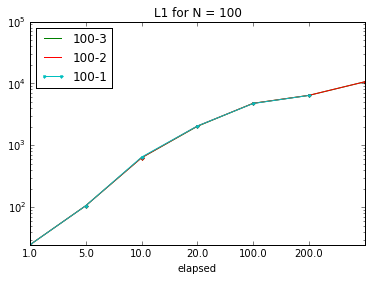

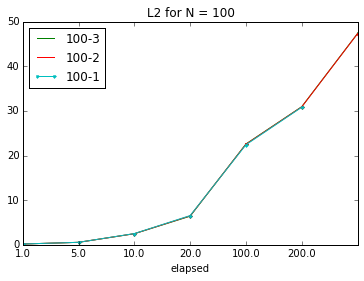

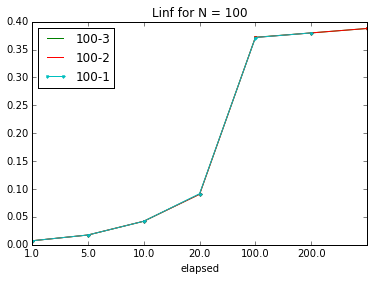

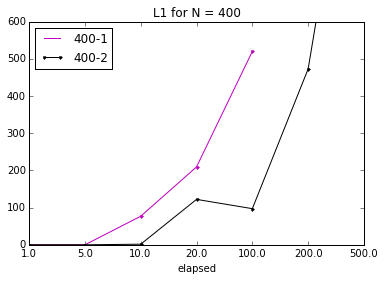

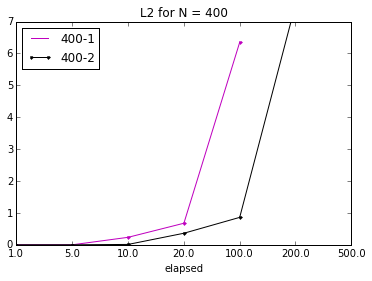

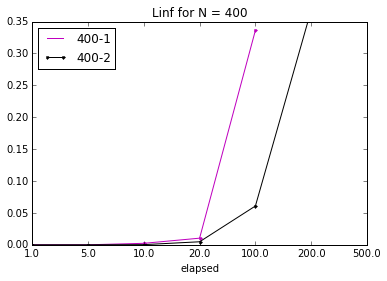

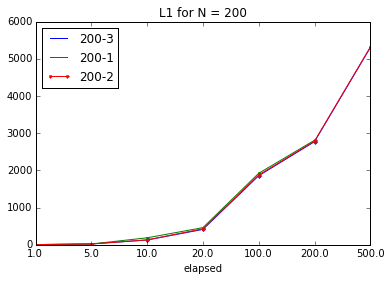

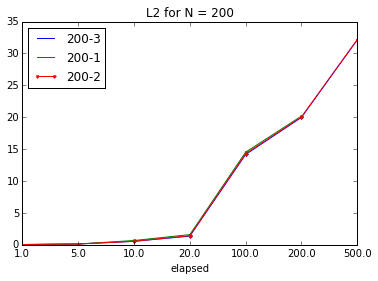

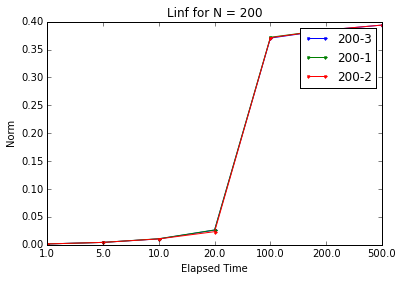

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
cycol = cycle('bgrcmk').next

print simulations

best_nx, best_sweeps = best_key.split('-')
temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(best_nx, best_sweeps))
color = cycol()
# ax = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.')
# temp_frame.plot('elapsed', 'L2', kind='line', ax = ax, ylim=0, c=color, marker='o')
# temp_frame.plot('elapsed', 'Linf', kind='line', ax = ax, ylim=0, c=color, marker='*')

graph_grids = []
for key in simulations:
    if key != best_key:
        nx, sweeps = key.split('-')
#         print 'Cells = ', nx
#         print 'Sweeps = ', sweeps
        color = cycol()
        temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(nx, sweeps))
        if nx not in graph_grids:
            print 'yay'
            graph_grids.append(nx)
            if int(nx)==100:
#                 print '100 yayyyyyyyyyyyyyyyyyyy'
                grids_100_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 100', label=key, logy=True)
                grids_100_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.',
                                               title='L2 for N = 100', label=key)
                grids_100_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.',
                                                 title='Linf for N = 100', label=key)
            
                grids_100_L1.set_xlim((0,1000))
                grids_100_L2.set_xlim((0,1000))
                grids_100_Linf.set_xlim((0,1000))
            if int(nx)==200:
#                 print '200 yay'
                grids_200_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                grids_200_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                grids_200_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
#                 print '400 yay'
                grids_400_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                grids_400_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                grids_400_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
        else:
            if int(nx)==100:
#                 print 'eleeeeeeeeee yay'
                temp_frame.plot('elapsed', 'L1', ax = grids_100_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 100', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_100_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 100', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_100_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 100', label=key)
            if int(nx)==200:
                temp_frame.plot('elapsed', 'L1', ax = grids_200_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_200_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_200_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
                temp_frame.plot('elapsed', 'L1', ax = grids_400_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_400_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_400_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
                
    
plt.ylabel('Norm')
plt.xlabel('Elapsed Time')
plt.legend()
plt.show()
            

In [15]:
temp_frame.

[Int64Index([52, 53, 54, 55, 56, 57, 58], dtype='int64'),
 Index([u'label', u'steps', u'elapsed', u'nx', u'ny', u'c_var_array',
        u'cvar_Interpolated_Function', u'dt', u'dx', u'dy', u'sweeps', u'L1',
        u'L2', u'Linf'],
       dtype='object')]

# Plot Norms for various sweeps 

to compare the Norms for various grid sizes at specific sweeps and elapsed time

In [79]:
print all_keys
print type(best_key)

['100-3-1.0', '100-3-5.0', '100-3-10.0', '100-3-20.0', '100-3-100.0', '100-3-200.0', '100-3-500.0', '100-2-1.0', '100-2-5.0', '100-2-10.0', '100-2-20.0', '100-2-100.0', '100-2-200.0', '100-2-500.0', '100-1-1.0', '100-1-5.0', '100-1-10.0', '100-1-20.0', '100-1-100.0', '100-1-200.0', '400-3-1.0', '400-3-5.0', '400-3-10.0', '400-3-20.0', '400-3-100.0', '400-3-200.0', '400-3-500.0', '400-1-1.0', '400-1-5.0', '400-1-10.0', '400-1-20.0', '400-1-100.0', '400-2-1.0', '400-2-5.0', '400-2-10.0', '400-2-20.0', '400-2-100.0', '400-2-200.0', '400-2-500.0']
<type 'str'>


['100-3-1.0', '100-3-5.0', '100-3-10.0', '100-3-20.0', '100-3-100.0', '100-3-200.0', '100-3-500.0', '100-2-1.0', '100-2-5.0', '100-2-10.0', '100-2-20.0', '100-2-100.0', '100-2-200.0', '100-2-500.0', '100-1-1.0', '100-1-5.0', '100-1-10.0', '100-1-20.0', '100-1-100.0', '100-1-200.0', '400-3-1.0', '400-3-5.0', '400-3-10.0', '400-3-20.0', '400-3-100.0', '400-3-200.0', '400-3-500.0', '400-1-1.0', '400-1-5.0', '400-1-10.0', '400-1-20.0', '400-1-100.0', '400-2-1.0', '400-2-5.0', '400-2-10.0', '400-2-20.0', '400-2-100.0', '400-2-200.0', '400-2-500.0']
           label steps elapsed   nx   ny  \
0   fafbeb433621    26     1.0  100  100   
1   fafbeb433621    43     5.0  100  100   
2   fafbeb433621    51    10.0  100  100   
3   fafbeb433621    62    20.0  100  100   
4   fafbeb433621   107   100.0  100  100   
5   fafbeb433621   168   200.0  100  100   
6   fafbeb433621   291   500.0  100  100   
20  87010a682e4d    26     1.0  400  400   
21  87010a682e4d    43     5.0  400  400   
22  87010a

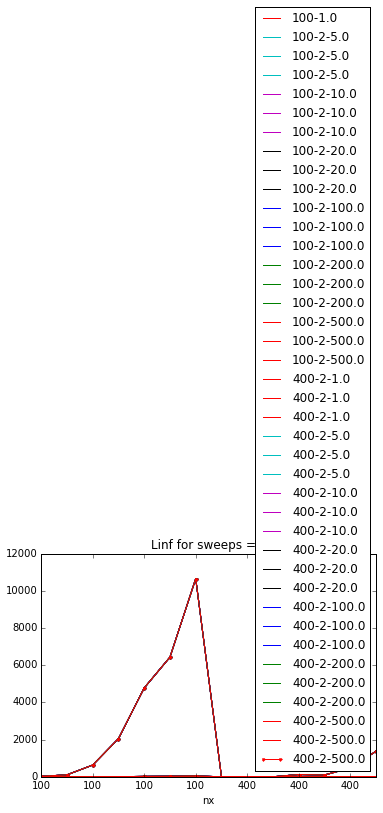

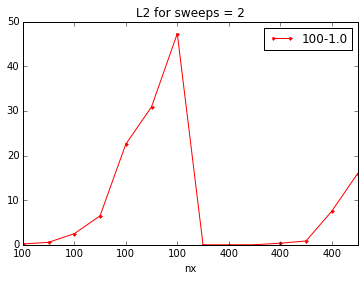

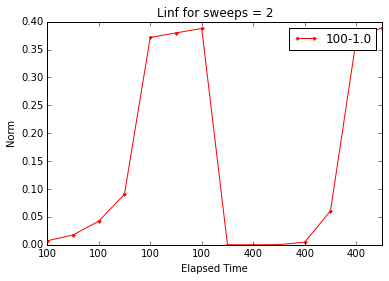

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
cycol = cycle('bgrcmk').next

print all_keys

best_nx, best_sweeps = best_key.split('-')
temp_best_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(best_nx, best_sweeps))
color = cycol()
# ax = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.')
# temp_frame.plot('elapsed', 'L2', kind='line', ax = ax, ylim=0, c=color, marker='o')
# temp_frame.plot('elapsed', 'Linf', kind='line', ax = ax, ylim=0, c=color, marker='*')

graphed_keys = []
for key in all_keys:
#     print 'KEYS:', key[:5], ' ', best_key
    if key[:5]!=best_key:
        nx, sweeps, elaps = key.split('-')
#         print 'Cells = ', nx
#         print 'Sweeps = ', sweeps
        color = cycol()
        temp_frame = dfC_final.query('(sweeps == {1})'.format(elaps, sweeps))  #(elapsed == {0}) &
        print temp_frame
#         sweeps_elaps = '{0}-{1}'.format(sweeps, elaps)
        if sweeps not in graphed_keys:
            print 'yay'
            graphed_keys.append(sweeps)
            if int(sweeps)==2:
#                 print '100 yayyyyyyyyyyyyyyyyyyy'
                sweeps_2_L1 = temp_frame.plot('nx', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for sweeps = 2', label='{0}-{1}'.format(nx, elaps))
                sweeps_2_L2 = temp_frame.plot('nx', 'L2', kind='line', ylim=0, c=color, marker='.',
                                               title='L2 for sweeps = 2', label='{0}-{1}'.format(nx, elaps))
                sweeps_2_Linf = temp_frame.plot('nx', 'Linf', kind='line', ylim=0, c=color, marker='.',
                                                 title='Linf for sweeps = 2', label='{0}-{1}'.format(nx, elaps))
            
                grids_100_L1.set_xlim((0,1000))
                grids_100_L2.set_xlim((0,1000))
                grids_100_Linf.set_xlim((0,1000))
            if int(nx)==200:
#                 print '200 yay'
                grids_200_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                grids_200_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                grids_200_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
#                 print '400 yay'
                grids_400_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                grids_400_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                grids_400_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
        else:
            if int(sweeps)==2:
#                 print 'eleeeeeeeeee yay'
                temp_frame.plot('nx', 'L1', ax = sweeps_2_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for sweeps = 2', label=key)
                temp_frame.plot('nx', 'L2', ax = sweeps_2_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for sweeps = 2', label=key)
                temp_frame.plot('nx', 'Linf', ax = sweeps_2_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for sweeps = 2', label=key)
            if int(nx)==200:
                temp_frame.plot('elapsed', 'L1', ax = grids_200_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_200_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_200_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
                temp_frame.plot('elapsed', 'L1', ax = grids_400_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_400_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_400_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
                
    
plt.ylabel('Norm')
plt.xlabel('Elapsed Time')
plt.legend()
plt.show()
            

# cvar Figures of Merit

Now we have everything we need in the dataframe and can compare the different grid sizes, calculate L2 using cvar etc

# Free Energy Interpolation

For this section, we have to take the elapsed time and cvar from each step file, calculate the energy at that step, then interpolate the array of energies along with time. Save the intepolated function into the SUMATRA dataframe

In [223]:
energyFunctions = []
energyFunctions.append(None)
print energyFunctions
print ' '
for row in df.iterrows():
    print row[1]['label']
    
df

#How to select a specific row and then you can change the values in it's columns
df.loc[df['label']==['bf22b1bfaef6']['datastore']

[None]
 
48841eea4a91
da25c86b72f0
bf22b1bfaef6
7f52183544f2
47235abe3a7b


2    {u'type': u'FileSystemDataStore', u'parameters...
Name: datastore, dtype: object

In [191]:
!pwd

/data/aem1/new1a/corr-sumatra-test


In [17]:
import os
import numpy as np
from scipy import interpolate as scpinter

results = {}
c_alpha = 0.3
c_beta = 0.7
kappa = 2.0
# M = 5.0
# c_0 = 0.5
# epsilon = 0.01
rho_s = 5.0

def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)

def f(c):
    return (f_0(c)+ .5*kappa*(np.linalg.norm(np.gradient(c)))**2)


def freeEnergyInterp(labels, dframe, Lx = 200.):
    test_dict = {}
    energyFunctions = []
    #This code will access every step file saved in the Data/[label] directory 
    for label in dframe['label']:
        e_elaps = []
        e_enrg = []
        filepath = os.path.join('/data/aem1/new1a/corr-sumatra2/Data', label)
        #gets the last step file in the directory (hopefully at equillibrium)
#         file = os.listdir('Data/{0}'.format(label))[len(os.listdir('Data/{0}'.format(label)))-2] 
        stepfiles = glob.glob('{0}/*.npz'.format(filepath)) #get the list of all step files for simulation
#         print stepfiles
        if len(stepfiles)==0: 
            energyFunctions.append(None)
        else:
            for stpfile in stepfiles:
                fn = np.load(stpfile)
                #do free enrgy math here

                cvar_array = fn['c_var_array']
                cells = fn['nx']*fn['ny']
                dx = Lx / fn['nx']
                dy = Lx / fn['ny']
                free_energy_array = f(cvar_array)
                free_energy_cellVolAvg = np.mean(free_energy_array)*cells*dx*dy
#                 f(c_var).cellVolumeAverage*cells*(dx**2)


                e_elaps.append(fn['elapsed'])
                e_enrg.append(free_energy_cellVolAvg)

        eFunction = scpinter.interp1d(e_elaps, e_enrg, copy=False)
        energyFunctions.append(eFunction) #save a list of all the energy functions
        print ' '
        print '='*100
        print 'Number of energy functions: ', len(energyFunctions) 
        
        
        #svae values into a dictionary to figure out why norms are 0 for grids 400
        if label not in test_dict.keys():
            test_dict[label] = {'elapsed':e_elaps, 'energy':e_enrg}
            
            
            
    dframe['Free_Energy_Interpolated_Function'] = energyFunctions #add the list as a new column to the dataframe
    return test_dict
labels = dfC_final['label']
print labels
test_dict = freeEnergyInterp(labels, dfC_final)
#             data = {'cvar':fn['cvar'], 'freeEn':float(fn['f']), 'step':int(fn['steps']), 'elapsed':float(fn['time'])}
#     #         print type(data)
#     #         print type(str(fn['grid']))
#             results.update({str(fn['grid']):data})


0     fafbeb433621
1     fafbeb433621
2     fafbeb433621
3     fafbeb433621
4     fafbeb433621
5     fafbeb433621
6     fafbeb433621
7     d88bca02dcc7
8     d88bca02dcc7
9     d88bca02dcc7
10    d88bca02dcc7
11    d88bca02dcc7
12    d88bca02dcc7
13    d88bca02dcc7
14    555a1eed5f55
15    555a1eed5f55
16    555a1eed5f55
17    555a1eed5f55
18    555a1eed5f55
19    555a1eed5f55
20    87010a682e4d
21    87010a682e4d
22    87010a682e4d
23    87010a682e4d
24    87010a682e4d
25    87010a682e4d
26    87010a682e4d
27    7eff0b0d7455
28    7eff0b0d7455
29    7eff0b0d7455
30    7eff0b0d7455
31    7eff0b0d7455
32    d5ba58775177
33    d5ba58775177
34    d5ba58775177
35    d5ba58775177
36    d5ba58775177
37    d5ba58775177
38    d5ba58775177
39    8851d4ef0b49
40    8851d4ef0b49
41    8851d4ef0b49
42    8851d4ef0b49
43    8851d4ef0b49
44    8851d4ef0b49
45    8851d4ef0b49
46    9656864915ad
47    9656864915ad
48    9656864915ad
49    9656864915ad
50    9656864915ad
51    9656864915ad
52    bc94d6

In [18]:
dfC_final
# dfC_final.query('label == "d5ba58775177"')

,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf,Free_Energy_Interpolated_Function
0,fafbeb433621,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,3,24.7367,0.176435,0.00723931,<scipy.interpolate.interpolate.interp1d object...
1,fafbeb433621,43,5.0,100,100,"[0.538726025473, 0.551850637422, 0.55003077790...",None,0.104952481839,2.0,2.0,3,105.874,0.555187,0.0175756,<scipy.interpolate.interpolate.interp1d object...
2,fafbeb433621,51,10.0,100,100,"[0.5833090875, 0.601243470851, 0.600634731549,...",None,0.276794734012,2.0,2.0,3,630.079,2.4837,0.0422189,<scipy.interpolate.interpolate.interp1d object...
3,fafbeb433621,62,20.0,100,100,"[0.592772135132, 0.606466476192, 0.60487321399...",None,0.444615342716,2.0,2.0,3,2031.19,6.41349,0.0907379,<scipy.interpolate.interpolate.interp1d object...
4,fafbeb433621,107,100.0,100,100,"[0.584911259609, 0.554134101807, 0.50933111079...",None,0.000477116988293,2.0,2.0,3,4785.38,22.5849,0.371876,<scipy.interpolate.interpolate.interp1d object...
5,fafbeb433621,168,200.0,100,100,"[0.537517884553, 0.504885738303, 0.46325649396...",None,1.96908172607,2.0,2.0,3,6431.18,30.9322,0.379721,<scipy.interpolate.interpolate.interp1d object...
6,fafbeb433621,291,500.0,100,100,"[0.445400625063, 0.41610932809, 0.388169791056...",None,1.22996861185,2.0,2.0,3,10645.4,47.3346,0.38767,<scipy.interpolate.interpolate.interp1d object...
7,d88bca02dcc7,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,2,24.7367,0.176435,0.00723931,<scipy.interpolate.interpolate.interp1d object...
8,d88bca02dcc7,43,5.0,100,100,"[0.538726112675, 0.551850748491, 0.55003087979...",None,0.104952481839,2.0,2.0,2,105.874,0.555187,0.0175757,<scipy.interpolate.interpolate.interp1d object...
9,d88bca02dcc7,51,10.0,100,100,"[0.583120426534, 0.6009981981, 0.60039883956, ...",None,0.276794734012,2.0,2.0,2,631.804,2.48869,0.0423026,<scipy.interpolate.interpolate.interp1d object...


# Figures of Merit

Now we need to use methods to add some figures of merit to the dataframes to compare the grids to the 400 grid

In [ ]:
for row in df.iterrows():

In [19]:
#add moose data as well
#This method takes any set of "ideal times" and compares the free energy values at those times for every simulation

ideal_times = []
for i in xrange(1, 180): ideal_times.append(i)
# ideal_times = [1, 5, 10]
print ideal_times

def FreeEnergyCompare(dframe, ideal_times):
    L1Norms = [] #should these be dictionaries to match with the proper simulation label? 
    L2Norms = []
    LinfNorms = []
    N_Best = 0
    sweeps_Best = 0
    
    for row in dframe.iterrows():
        if row[1]['nx'] >= N_Best and row[1]['sweeps'] >= sweeps_Best:
            BestEnergyFunct = row[1]['Free_Energy_Interpolated_Function']
            N_Best = row[1]['nx']
            sweeps_Best = row[1]['sweeps']
    for row in dframe.iterrows():    
        efunction = row[1]['Free_Energy_Interpolated_Function']
        diff = np.absolute(efunction(ideal_times) - BestEnergyFunct(ideal_times))
        L1Norms.append(np.linalg.norm(diff,1)) 
        L2Norms.append(np.linalg.norm(diff,2)) 
        LinfNorms.append(np.linalg.norm(diff, np.inf)) 
    
    
    dframe['L1 Free Energy Norms'] = L1Norms
    dframe['L2 Free Energy Norms'] = L2Norms
    dframe['L-infinite Free Energy Norms'] = LinfNorms
    #Anushkas code
#     diff_50.append(np.absolute(y50x4[ideal_times] - y400x5[ideal_times]))
#     L1Norms.append(np.linalg.norm(diff_50,1))
#     L2Norms.append(np.linalg.norm(diff_50,2))
#     LinfNorms.append(np.linalg.norm(diff_50, np.inf))

FreeEnergyCompare(dfC_final, ideal_times)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]


In [31]:
dfC_final

100

# Free  Energy Norm graphing

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
cycol = cycle('bgrcmk').next

print simulations

best_nx, best_sweeps = best_key.split('-')
temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(best_nx, best_sweeps))
color = cycol()
# ax = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.')
# temp_frame.plot('elapsed', 'L2', kind='line', ax = ax, ylim=0, c=color, marker='o')
# temp_frame.plot('elapsed', 'Linf', kind='line', ax = ax, ylim=0, c=color, marker='*')

graph_grids = []
for key in simulations:
    if key != best_key:
        nx, sweeps = key.split('-')
#         print 'Cells = ', nx
#         print 'Sweeps = ', sweeps
        color = cycol()
        temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(nx, sweeps))
        if nx not in graph_grids:
            print 'yay'
            graph_grids.append(nx)
            if int(nx)==100:
#                 print '100 yayyyyyyyyyyyyyyyyyyy'
                Energy_N100_L1_graph = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L1 for N = 100', label=key)
                Energy_N100_L2_graph = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.',
                                               title='Free Energy L2 for N = 100', label=key)
                Energy_N100_Linf_graph = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.',
                                                 title='Free Energy Linf for N = 100', label=key)
            if int(nx)==200:
#                 print '200 yay'
                grids_200_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L1 for N = 200', label=key)
                grids_200_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L2 for N = 200', label=key)
                grids_200_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy Linf for N = 200', label=key)
            if int(nx)==400:
#                 print '400 yay'
                grids_400_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L1 for N = 400', label=key)
                grids_400_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L2 for N = 400', label=key)
                grids_400_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy Linf for N = 400', label=key)
        else:
            if int(nx)==100:
#                 print 'eleeeeeeeeee yay'
                temp_frame.plot('elapsed', 'L1', ax = grids_100_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 100', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_100_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 100', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_100_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 100', label=key)
            if int(nx)==200:
                temp_frame.plot('elapsed', 'L1', ax = grids_200_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_200_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_200_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
                temp_frame.plot('elapsed', 'L1', ax = grids_400_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_400_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_400_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
                
    
plt.ylabel('norm')
plt.xlabel('elapsed')
plt.legend()

,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf,Free_Energy_Interpolated_Function,L1 Free Energy Norms,L2 Free Energy Norms,L-infinite Free Energy Norms
0,930d7803d43c,19,0.5,400,400,"[0.50673233667, 0.508385740277, 0.509895251232...",None,0.0440082686508,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...,0.000000,0.000000,0.000000
1,930d7803d43c,26,1.0,400,400,"[0.506896655988, 0.508563642028, 0.51010800093...",None,0.0710184637685,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...,0.000000,0.000000,0.000000
2,930d7803d43c,52,10.0,400,400,"[0.534176225054, 0.541906158813, 0.54898882738...",None,0.14020960391,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...,0.000000,0.000000,0.000000
3,c04ef730f8a4,19,0.5,50,50,"[0.531568565867, 0.524867525329, 0.51452037813...",None,0.0440082686508,4.0,4,1,5206.07,13.4047,0.0581749,<scipy.interpolate.interpolate.interp1d object...,321440.977996,125686.991715,69643.988079
4,c04ef730f8a4,26,1.0,50,50,"[0.535429868073, 0.528178117566, 0.51580079118...",None,0.0710184637685,4.0,4,1,5866.3,15.0605,0.0648757,<scipy.interpolate.interpolate.interp1d object...,321440.977996,125686.991715,69643.988079
5,c04ef730f8a4,51,10.0,50,50,"[0.609652339928, 0.605505470278, 0.57235280566...",None,0.459644859611,4.0,4,1,17395.1,48.0488,0.261789,<scipy.interpolate.interpolate.interp1d object...,321440.977996,125686.991715,69643.988079
6,07a1f812ebe3,19,0.5,50,50,"[0.531568565842, 0.52486752533, 0.51452037814,...",None,0.0440082686508,4.0,4,2,5206.07,13.4047,0.0581749,<scipy.interpolate.interpolate.interp1d object...,336374.031220,131610.106649,72962.444352
7,07a1f812ebe3,26,1.0,50,50,"[0.535429867575, 0.528178117559, 0.51580079119...",None,0.0710184637685,4.0,4,2,5866.3,15.0605,0.0648757,<scipy.interpolate.interpolate.interp1d object...,336374.031220,131610.106649,72962.444352
8,07a1f812ebe3,51,10.0,50,50,"[0.608248244075, 0.604199034199, 0.57144701935...",None,0.283249889094,4.0,4,2,17169.2,47.5165,0.260306,<scipy.interpolate.interpolate.interp1d object...,336374.031220,131610.106649,72962.444352
9,00b64e9db978,19,0.5,100,100,"[0.517433869448, 0.522449680241, 0.51992540421...",None,0.0440082686508,2.0,2,2,1943.13,5.64167,0.0372392,<scipy.interpolate.interpolate.interp1d object...,737422.389702,290301.538867,161691.572364


# Memory vs CPU time graphing

Now we will plot Memory Usage vs CPU for various grid sizes 

the color of the dot corresponds to how small the Norm for that grid size is (green = smallest)

In [37]:
float(dfC_final.query('(label=="d88bca02dcc7")').iloc[0]['L2 Free Energy Norms'])

4579282.3231437905

In [50]:
df

,datastore,dependencies,diff,duration,executable,input_data,input_datastore,label,launch_mode,main_file,...,platforms,reason,repeats,repository,script_arguments,stdout_stderr,tags,timestamp,user,version
0,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'pygments', u'module': u'python', ...",,5.243620,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",31a1702e3986,"{u'type': u'SerialLaunchMode', u'parameters': ...",1a_commandlineNew.py,...,"[{u'system_name': u'Linux', u'ip_addr': u'127....",,None,"{u'url': u'/data/aem1/new1a/corr-sumatra2', u'...",<parameters>,"my params: {u'N': 50, u'steps': 100, u'sweeps'...",[],2016-06-28 16:13:06,Andrey Moskalenko <andrey.moskalenko@nist.gov>,63c5dd0c7b5600781be262f7ba720463096c1005
1,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'pygments', u'module': u'python', ...",diff --git a/1a_commandlineNew.py b/1a_command...,9840.101632,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",930d7803d43c,"{u'type': u'SerialLaunchMode', u'parameters': ...",1a_commandlineNew.py,...,"[{u'system_name': u'Linux', u'ip_addr': u'127....",,None,"{u'url': u'/data/aem1/new1a/corr-sumatra2', u'...",<parameters>,"my params: {u'N': 400, u'steps': 100, u'sweeps...",[],2016-06-28 16:26:01,Andrey Moskalenko <andrey.moskalenko@nist.gov>,63c5dd0c7b5600781be262f7ba720463096c1005
2,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'pygments', u'module': u'python', ...",diff --git a/1a_commandlineNew.py b/1a_command...,27.170567,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",c04ef730f8a4,"{u'type': u'SerialLaunchMode', u'parameters': ...",1a_commandlineNew.py,...,"[{u'system_name': u'Linux', u'ip_addr': u'127....",,None,"{u'url': u'/data/aem1/new1a/corr-sumatra2', u'...",<parameters>,"my params: {u'N': 50, u'steps': 100, u'sweeps'...",[],2016-06-28 16:18:41,Andrey Moskalenko <andrey.moskalenko@nist.gov>,63c5dd0c7b5600781be262f7ba720463096c1005
3,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'pygments', u'module': u'python', ...",diff --git a/1a_commandlineNew.py b/1a_command...,36.534400,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",07a1f812ebe3,"{u'type': u'SerialLaunchMode', u'parameters': ...",1a_commandlineNew.py,...,"[{u'system_name': u'Linux', u'ip_addr': u'127....",,None,"{u'url': u'/data/aem1/new1a/corr-sumatra2', u'...",<parameters>,"my params: {u'N': 50, u'steps': 100, u'sweeps'...",[],2016-06-28 16:19:38,Andrey Moskalenko <andrey.moskalenko@nist.gov>,63c5dd0c7b5600781be262f7ba720463096c1005
4,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'pygments', u'module': u'python', ...",diff --git a/1a_commandlineNew.py b/1a_command...,144.385296,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",00b64e9db978,"{u'type': u'SerialLaunchMode', u'parameters': ...",1a_commandlineNew.py,...,"[{u'system_name': u'Linux', u'ip_addr': u'127....",,None,"{u'url': u'/data/aem1/new1a/corr-sumatra2', u'...",<parameters>,"my params: {u'N': 100, u'steps': 100, u'sweeps...",[],2016-06-28 16:20:46,Andrey Moskalenko <andrey.moskalenko@nist.gov>,63c5dd0c7b5600781be262f7ba720463096c1005
5,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'pygments', u'module': u'python', ...",diff --git a/1a_commandlineNew.py b/1a_command...,125.821201,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",8be118ae3c21,"{u'type': u'SerialLaunchMode', u'parameters': ...",1a_commandlineNew.py,...,"[{u'system_name': u'Linux', u'ip_addr': u'127....",,None,"{u'url': u'/data/aem1/new1a/corr-sumatra2', u'...",<parameters>,"my params: {u'N': 100, u'steps': 100, u'sweeps...",[],2016-06-28 16:23:53,Andrey Moskalenko <andrey.moskalenko@nist.gov>,63

# Create a dataframe for the memory data to graph it

In [70]:
#what are the simulations we are concerned with?
sim_labels = ['fafbeb433621', 'd88bca02dcc7', '555a1eed5f55', '87010a682e4d', '7eff0b0d7455', 'd5ba58775177', '8851d4ef0b49', '9656864915ad', 'bc94d63e65a8' ]
dfMem = pandas.DataFrame(columns=['label','steps','sumatra duration', 'elapsed', 'nx', 'sweeps', 'memory usage', 'L1 Free Energy', 'L2 Free Energy', 'Linf Free Energy'])
rows = 0
data_dict = {} #the dictionary to which we will add data

with open('memory_peaks.json') as ff:
    memory_data = json.load(ff)
print memory_data #this is the memory data we will use for all simulations
    
for label in sim_labels:
#     print type(label)
#     label = str(label)
    temp_df = df.query('(label == "{0}")'.format(label))
    #build the dictionary to add to the memory dataframe
    data_dict['sumatra duration'] = float(temp_df['duration'])
    data_dict['label'] = label   
    data_dict['steps'] = 0
    data_dict['elapsed'] = 0
    data_dict['nx'] = int(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['nx'])
    data_dict['sweeps'] = int(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['sweeps'])
    data_dict['memory usage'] = memory_data[str(data_dict['nx'])]
    data_dict['L1 Free Energy'] = float(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['L1 Free Energy Norms'])
    data_dict['L2 Free Energy'] = float(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['L2 Free Energy Norms'])
    data_dict['Linf Free Energy'] = float(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['L-infinite Free Energy Norms'])
    
    dfMem.loc[rows]=data_dict
    rows +=1
    
# dfMem['label'] = sim_labels
dfMem

{u'200': 357.707031, u'100': 150.066406, u'50': 110.140625, u'400': 1120.996094}


,label,steps,sumatra duration,elapsed,nx,sweeps,memory usage,L1 Free Energy,L2 Free Energy,Linf Free Energy
0,fafbeb433621,0.0,960.674674,0.0,100.0,3.0,150.066406,5.897538e+07,4.680586e+06,535623.528792
1,d88bca02dcc7,0.0,1109.272300,0.0,100.0,2.0,150.066406,5.762113e+07,4.579282e+06,545832.083483
2,555a1eed5f55,0.0,1891.935890,0.0,100.0,1.0,150.066406,5.613717e+07,4.469860e+06,566528.738040
3,87010a682e4d,0.0,76026.597423,0.0,400.0,3.0,1120.996094,0.000000e+00,0.000000e+00,0.000000
4,7eff0b0d7455,0.0,98401.122121,0.0,400.0,1.0,1120.996094,6.348818e+06,5.742908e+05,82506.230199
5,d5ba58775177,0.0,116402.417088,0.0,400.0,2.0,1120.996094,2.793446e+06,2.965901e+05,121084.900350
6,8851d4ef0b49,0.0,9294.456187,0.0,200.0,3.0,357.707031,2.418578e+07,1.879007e+06,174864.964327
7,9656864915ad,0.0,14459.664805,0.0,200.0,1.0,357.707031,2.156829e+07,1.679103e+06,154003.494783
8,bc94d63e65a8,0.0,14049.452955,0.0,200.0,2.0,357.707031,2.268021e+07,1.779636e+06,163110.198000


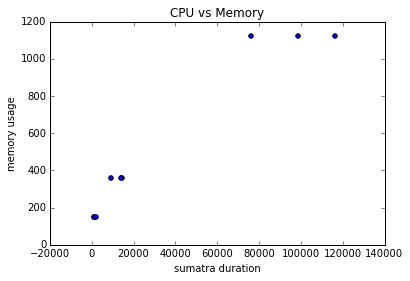

In [72]:
memory_plot = dfMem.plot('sumatra duration', 'memory usage', kind='scatter', ylim=0, title='CPU vs Memory')

# Energy_N100_L1_graph = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
#                                                title='Free Energy L1 for N = 100', label=key)

In [66]:
label = 'fafbeb433621'
df.query('(label == "{0}")'.format(label))

with open('memory_peaks.json') as ff:
    memory_data = json.load(ff)
    print memory_data['100']

150.066406


In [155]:
dfC_final

,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf,Free_Energy_Interpolated_Function,L1 Free Energy Norms,L2 Free Energy Norms,L-infinite Free Energy Norms
0,fafbeb433621,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,3,24.7367,0.176435,0.00723931,<scipy.interpolate.interpolate.interp1d object...,5.897538e+07,4.680586e+06,535623.528792
1,fafbeb433621,43,5.0,100,100,"[0.538726025473, 0.551850637422, 0.55003077790...",None,0.104952481839,2.0,2.0,3,105.874,0.555187,0.0175756,<scipy.interpolate.interpolate.interp1d object...,5.897538e+07,4.680586e+06,535623.528792
2,fafbeb433621,51,10.0,100,100,"[0.5833090875, 0.601243470851, 0.600634731549,...",None,0.276794734012,2.0,2.0,3,630.079,2.4837,0.0422189,<scipy.interpolate.interpolate.interp1d object...,5.897538e+07,4.680586e+06,535623.528792
3,fafbeb433621,62,20.0,100,100,"[0.592772135132, 0.606466476192, 0.60487321399...",None,0.444615342716,2.0,2.0,3,2031.19,6.41349,0.0907379,<scipy.interpolate.interpolate.interp1d object...,5.897538e+07,4.680586e+06,535623.528792
4,fafbeb433621,107,100.0,100,100,"[0.584911259609, 0.554134101807, 0.50933111079...",None,0.000477116988293,2.0,2.0,3,4785.38,22.5849,0.371876,<scipy.interpolate.interpolate.interp1d object...,5.897538e+07,4.680586e+06,535623.528792
5,fafbeb433621,168,200.0,100,100,"[0.537517884553, 0.504885738303, 0.46325649396...",None,1.96908172607,2.0,2.0,3,6431.18,30.9322,0.379721,<scipy.interpolate.interpolate.interp1d object...,5.897538e+07,4.680586e+06,535623.528792
6,fafbeb433621,291,500.0,100,100,"[0.445400625063, 0.41610932809, 0.388169791056...",None,1.22996861185,2.0,2.0,3,10645.4,47.3346,0.38767,<scipy.interpolate.interpolate.interp1d object...,5.897538e+07,4.680586e+06,535623.528792
7,d88bca02dcc7,26,1.0,100,100,"[0.516982487986, 0.522746851587, 0.52091822429...",None,0.0165294056612,2.0,2.0,2,24.7367,0.176435,0.00723931,<scipy.interpolate.interpolate.interp1d object...,5.762113e+07,4.579282e+06,545832.083483
8,d88bca02dcc7,43,5.0,100,100,"[0.538726112675, 0.551850748491, 0.55003087979...",None,0.104952481839,2.0,2.0,2,105.874,0.555187,0.0175757,<scipy.interpolate.interpolate.interp1d object...,5.762113e+07,4.579282e+06,545832.083483
9,d88bca02dcc7,51,10.0,100,100,"[0.583120426534, 0.6009981981, 0.60039883956, ...",None,0.276794734012,2.0,2.0,2,631.804,2.48869,0.0423026,<scipy.interpolate.interpolate.interp1d object...,5.762113e+07,4.579282e+06,545832.083483


In [31]:
for p in 'N', 'steps', 'sweeps':
    df[p] = df.parameters.map(lambda x: json.loads(x['content'])[p])

In [ ]:
print df['parameters'][0]['content']

In [37]:
df['Free Energy']=results['10x1']['freeEn']
df['elapsed']=results['10x1']['elapsed']

columns.append('Free Energy')
columns.append('elapsed')
df[columns]

,label,N,steps,tags,duration,sweeps,memory,Free Energy,elapsed
0,8f1f49c60b96,10,20,[npzTest],4.042712,2,4648.0,0.786517,0.57275


In [33]:
columns = ['label', 'N', 'steps', 'tags', 'duration', 'sweeps']
print df[columns]

          label   N  steps       tags  duration  sweeps
0  8f1f49c60b96  10     20  [npzTest]  4.042712       2


In [34]:
import numpy as np
import os
num = 0
memoryArray = np.array([])
for num in range(len(df.index)):
    memName = df['output_data'][num][len(df['output_data'][num])-1]['path']
    memlocation = df['datastore'][num]['parameters']['root']
    pool = os.path.join(memlocation, memName)
    memdata = np.loadtxt(pool)
    memoryArray = np.append(memoryArray, memdata)
    print memoryArray
    print ' '
    print num

[ 4648.]
 
0


In [35]:
df['memory']=memoryArray
columns.append('memory')
df[columns]

,label,N,steps,tags,duration,sweeps,memory
0,8f1f49c60b96,10,20,[npzTest],4.042712,2,4648.0


In [38]:
data = {'a' : [1, 2, 3], 'b' : [4, 5, 6]}
pandas.DataFrame(data)

,a,b
0,1,4
1,2,5
2,3,6


In [59]:
data = [{'a' : 1, 'b' : 4}, {'a' : 2, 'b' : 5}, {'a' : 3 ,'b' : 6}]
aa  = pandas.DataFrame(data)

In [60]:
def recalc(row):
    return row.b * 2

In [61]:
print aa

   a  b
0  1  4
1  2  5
2  3  6


In [ ]:
aa['c'] = [recalc(row) for index, row in aa.iterrows()]
print aa

In [73]:
times = np.array([0., 1.0, 1.5])
values = times**2


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(times, values)

In [ ]:
import numpy as np
np.linspace(0., 100., 1000)

In [83]:
!ls Data/1de38ff12ec7/
import glob
glob.glob('Data/1de38ff12ec7/*.npz')

1a10x1step0.npz  1a10x1step10.npz  1a10x1step20.npz  memory_usage.txt


['Data/1de38ff12ec7/1a10x1step0.npz',
 'Data/1de38ff12ec7/1a10x1step10.npz',
 'Data/1de38ff12ec7/1a10x1step20.npz']

# Outdated codes

In [ ]:
print 'This import takes a while and I dont know why'
from scipy import interpolate as scpinter
#from scipy.interpolate import interp2d as scpinter    
print 'importing done'
def cvarInterp(cvarFrame, Lx = 200.):
    for variables in dfC.iterrows():
        dictt = {}
#         print variables
        nx = variables[1]['nx']
        ny = variables[1]['ny']
        m = fp.Grid2D(nx = nx, ny= ny, dx=Lx / nx, dy=Lx / ny)
        x = m.x
        y = m.y
#         dictt.update({'x':m.x})
#         dictt.update({'y':m.y})
        cvar = variables[1]['c_var_array']
        function = scpinter.interp2d(x, y, cvar, copy=False)
        variables[1]['cvar_Interpolated_Function'] = function #set the interpolated function into the dataframe column
cvarInterp(dfC)

In [ ]:
cvar_times = []
#smtfram is the datafram created by sumatra records
#dframe is the table we create from .mpz.npz files because it can have multiple entries for the same simulation in order to compare the concentration values at different times
def CvarCompare(dframe, smtframe, Lx=200):
    L1_cvar_Norms = [] #should these be dictionaries to match with the proper simulation label? 
    L2_cvar_Norms = []
    Linf_cvar_Norms = []
    N_Best = 0
    sweeps_Best = 0
    
    labels = smtframe['label']
    
    times = []
    for x in dframe['elapsed']: times.append(int(x))
    times = list(set(times)) 
    print times
    for x in range(len(times)):
        times[x] = int(times[x]) #a list of the unique times where we sampled c_var
    
    times = [0.5, 1.0, 10.0] #manually entered these because it was crashing when one of the times was 0.5 seconds and rounding to 0
    print times
    
    L1_cvar_times = dict(('L1_cvar_time_{0}'.format(time), []) for time in times)
    L2_cvar_times = dict(('L2_cvar_time_{0}'.format(time), []) for time in times)
    Linf_cvar_times = dict(('Linf_cvar_time_{0}'.format(time), []) for time in times)

    print 'L1: '
    print L1_cvar_times
    print 'L2: '
    print L2_cvar_times
    print 'Linf: '
    print Linf_cvar_times
    #first we need to figure out which is the finest grid to set it as the standard of comparison
    for row in dframe.iterrows():
        if row[1]['nx']>N_Best and row[1]['sweeps']>sweeps_Best:
            Best_cvar_function = row[1]['cvar_Interpolated_Function']
            N_Best = row[1]['nx']
            sweeps_Best = row[1]['sweeps']
    #now for every sumatra label, go thorugh the dframe, and make lists for each norm and each sampled time 
    for label in labels:
        for row in dframe.iterrows():  
            if row[1]['label']==label:
                cvar_function = row[1]['cvar_Interpolated_Function']
                elapsed = row[1]['elapsed']
                nx = row[1]['nx']
                ny = row[1]['ny']
                m = fp.Grid2D(nx = nx, ny= ny, dx=Lx / nx, dy=Lx / ny)
                x = m.x
                y = m.y
                diff = np.absolute(cvar_function(x,y) - Best_cvar_function(x,y))
                
                L1_cvar_times['L1_cvar_time_{0}'.format(elapsed)].append(np.linalg.norm(diff,1))
                L2_cvar_times['L2_cvar_time_{0}'.format(elapsed)].append(np.linalg.norm(diff,2))
                Linf_cvar_times['Linf_cvar_time_{0}'.format(elapsed)].append(np.linalg.norm(diff,np.inf))

                
    #add the norms data to the sumatra database as seperate columns             
    for key in L1_cvar_times.keys():
        smtframe[key] = L1_cvar_times[key]
    for key in L2_cvar_times.keys():
        smtframe[key] = L2_cvar_times[key]         
    for key in Linf_cvar_times.keys():
        smtframe[key] = Linf_cvar_times[key]    
                 
    return smtframe
#                 try:
#                     L1_cvar_time_{0}.format(elapsed).append(np.linalg.norm(diff,1))
#                     L2_cvar_time_{0}.format(elapsed).append(np.linalg.norm(diff,2))
#                     L3_cvar_time_{0}.format(elapsed).append(np.linalg.norm(diff,3))
#                 except:
#                     L1_cvar_time_{0}.format(elapsed)=[np.linalg.norm(diff,1)]
#                     L2_cvar_time_{0}.format(elapsed)=[np.linalg.norm(diff,2)]
#                     L3_cvar_time_{0}.format(elapsed)=[np.linalg.norm(diff,3)]
#     for x in times:
#         smtframe['L1_cvar_time_{0}'.format(x)] = L1_cvar_time_{0}.format(x)
#         smtframe['L2_cvar_time_{0}'.format(x)] = L2_cvar_time_{0}.format(x)
#         smtframe['L3_cvar_time_{0}'.format(x)] = L3_cvar_time_{0}.format(x)
 
        
#     smtframe['L1 cvar Norms time:{0}'] = L1Norms
#     smtframe['L2 Norms'] = L2Norms
#     smtframe['L-infinite Norms'] = LinfNorms
#     return True
                 
CvarCompare(dfC, df)

In [ ]:

#to check why my free energy norms were 0 for all 400 grid sims
test_dict.keys()
math = []
print test_dict['7eff0b0d7455']['energy']
print ' '
print test_dict['d5ba58775177']['energy']
print '='*100
print test_dict['7eff0b0d7455']['elapsed']
print ' '
print test_dict['d5ba58775177']['elapsed']

print ' '
for x in xrange(len(test_dict['7eff0b0d7455']['elapsed'])):
    print 'diff = ', test_dict['7eff0b0d7455']['elapsed'][x] - test_dict['d5ba58775177']['elapsed'][x]
    
print '='*100
for x in xrange(len(test_dict['7eff0b0d7455']['energy'])):
    print 'energy diff = ', test_dict['7eff0b0d7455']['energy'][x] - test_dict['d5ba58775177']['energy'][x]
    math.append(float(test_dict['7eff0b0d7455']['energy'][x] - test_dict['d5ba58775177']['energy'][x]))
# dfC_final

print math
print (sum(math))